# Decision Tree

## Methods

A Decision Tree (DT) is a method used in data analysis that resembles a tree structure in its operation. It's a series of sequential decisions, each branching out based on the characteristics of the data. In each step, the decision tree looks at one aspect of the data and decides which way to go next, just like following a path based on signposts.

The primary goal of a Decision Tree is to split the data into distinct groups based on certain features. For instance, when analyzing stock prices, a decision tree might split the data based on whether the stock's price was above or below a certain threshold on a given day. These splits are chosen to best separate the data into groups with different behaviors or characteristics.

However, Decision Trees can sometimes oversimplify or overfit the data. This means they might not perform well when faced with new, unseen data because they've become too tailored to the specific data they were trained on.

To address this, we often use the Random Forest (RF) approach. This method combines the predictions of multiple Decision Trees to improve accuracy and reliability. Each tree in a Random Forest is built from a randomly selected subset of the data, making each tree a bit different. When it's time to make a prediction, the Random Forest takes an average or a majority vote of all these trees. This ensemble approach helps in balancing out biases and errors of individual trees, leading to better performance on new, unseen data.

From a big-picture perspective, both Decision Trees and Random Forests are methods used to analyze complex datasets and make predictions. They are particularly useful in situations where the relationships in the data are not immediately obvious. In the context of stock prices, these methods help in identifying patterns and trends that might indicate future price movements, offering valuable insights for decision-making processes.


In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd

AAPL = pd.read_csv('AAPL_Cleaned.csv')
AAPL.head()

df = AAPL.drop(columns=['Unnamed: 0', 'timestamp', 'open', 'close'])
df.dropna()


,high,low,volume,daily_return
1,190.05,187.4511,43389519,-2.062868
2,191.56,189.2300,45704823,0.955498
3,190.32,188.1900,48794366,-0.674545
4,192.09,188.9700,43014224,-0.305344
5,191.08,189.4000,38415419,0.543909
...,...,...,...,...
118,186.99,184.2700,101256225,-0.048646
119,186.52,183.7800,65433166,0.589444
120,184.39,182.0200,57462882,-1.107467
121,184.15,182.4400,54929129,-0.347921


In [2]:
X = df[['high', 'low']]
y = df['daily_return']
df['daily_return'].fillna(df['daily_return'].mean(), inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

rmse, model



(1.3036617804945074, DecisionTreeRegressor(random_state=42))

## Class distribution and Baseline model for comparison

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.dummy import DummyClassifier


df['return_class'] = (df['daily_return'] > 0).astype(int)
class_counts = df['return_class'].value_counts()
print(class_counts)

X = df[['high', 'low', 'volume']]
y = df['return_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

dummy_uniform = DummyClassifier(strategy="uniform", random_state=42)
dummy_uniform.fit(X_train, y_train)
y_pred_uniform = dummy_uniform.predict(X_test)

accuracy_uniform = accuracy_score(y_test, y_pred_uniform)
precision_uniform = precision_score(y_test, y_pred_uniform, zero_division=0)
recall_uniform = recall_score(y_test, y_pred_uniform, zero_division=0)

dummy_stratified = DummyClassifier(strategy="stratified", random_state=42)
dummy_stratified.fit(X_train, y_train)
y_pred_stratified = dummy_stratified.predict(X_test)

accuracy_stratified = accuracy_score(y_test, y_pred_stratified)
precision_stratified = precision_score(y_test, y_pred_stratified, zero_division=0)
recall_stratified = recall_score(y_test, y_pred_stratified, zero_division=0)

(accuracy_uniform, precision_uniform, recall_uniform), (accuracy_stratified, precision_stratified, recall_stratified)


return_class
0    69
1    54
Name: count, dtype: int64


((0.56, 0.36363636363636365, 0.5), (0.56, 0.3333333333333333, 0.375))

The classification typically classify the dataset into 2 groups, positive daily return and negative daily return. The dataset is raletively balanced as it has almost half and half for both 0 and 1. The uniform strategy classifier performs better than the stratified classifier, with a higher accuracy of 56%.

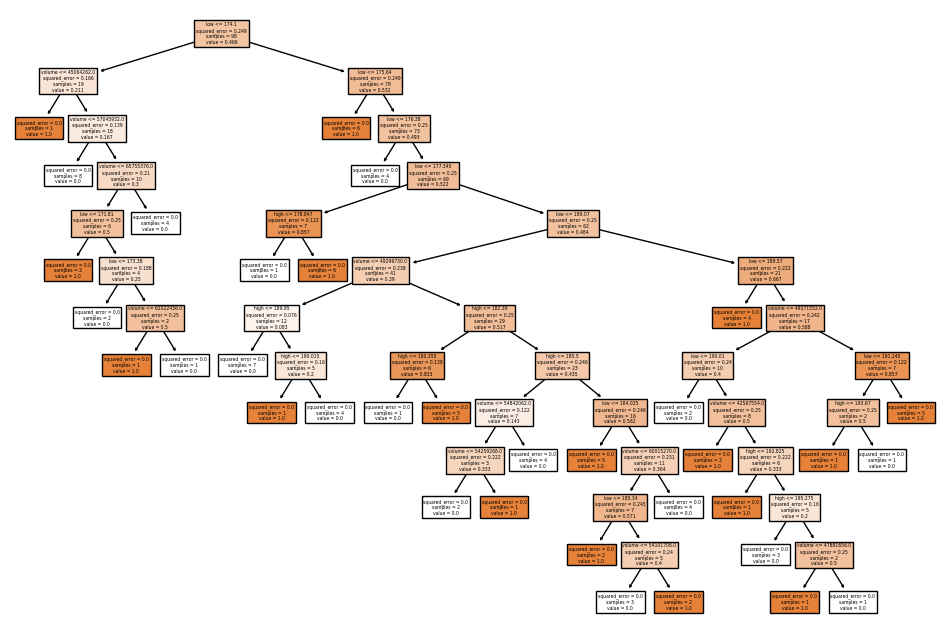

In [4]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names_list = X.columns.tolist()
plt.figure(figsize=(12,8))
plot_tree(model, filled=True, feature_names=feature_names_list)
plt.show()

## Model tuning

Best parameters: {'max_depth': 1, 'min_samples_leaf': 8, 'min_samples_split': 2}
Best score: -0.25854706191243626


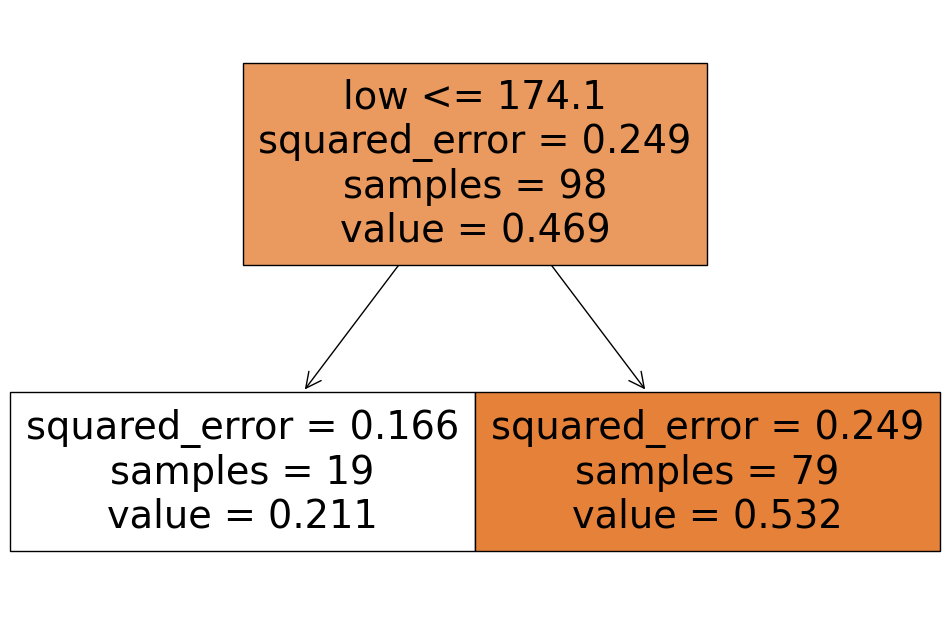

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}
dtree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best score:", best_score)

optimal_model = DecisionTreeRegressor(**best_params, random_state=42)
optimal_model.fit(X_train, y_train)

plt.figure(figsize=(12,8))
plot_tree(optimal_model, filled=True, feature_names=feature_names_list)
plt.show()

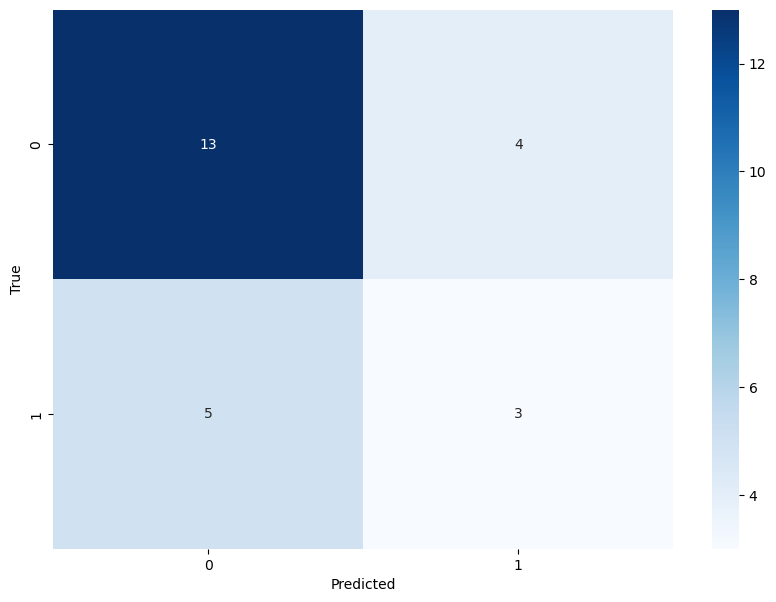

In [6]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Final results

The optimal decision tree has too few leaves, it might due to that the dataset does not fit the decision tree algorithm very well. It could be imporved by setting other parameters but those might not be the optimal choice. 

The plot of confusion matrix shows that the there's a high number of correct prediction (13 on true positive, 3 on false negative) and small number of incorrect prediction (5 on false positive and 4 on true negative), indicating that the model overall perform well in predicting.

## Conclusion

In our analysis of Apple's stock prices, the decision tree model we used to predict daily returns turned out to be quite basic, with only two outcomes. This indicates that the model may not fully capture the complexities and variables that drive the stock market's fluctuations. The model's simplicity could suggest that it's not adequately tailored to the nuances of stock price movements. Stock prices can be influenced by a number of factors, ranging from company performance and investor sentiment to broader economic indicators. A model with only two branches may not account for these diverse influences adequately.

However, even with its limited structure, the model managed to correctly predict the direction of stock price movement with a degree of accuracy. While it certainly didn't catch every nuance, the high number of correct predictions indicates that the model has captured some underlying trends in the data. It seems to have identified a basic pattern in the stock's movements that, more often than not, pointed in the right direction.

The key takeaway here is that while the decision tree provided some correct predictions, its oversimplified structure suggests there is much room for improvement. By incorporating more data or trying different modeling techniques, we might develop a more sophisticated model that can better navigate the intricacies of stock market predictions. With further refinement, we aim to enhance the accuracy and reliability of our predictions, ultimately striving for a model that closely aligns with the dynamic nature of the stock market.